### Preparation of reference data (Rosario)

Data downloaded from [Open Data published by Municipality of Rosario](https://datosabiertos.rosario.gob.ar/dataset/ciclovías-y-bicisendas) 

#### Run code below with different kernel/env (`qgis` needed),

**after**

1. filling out config file
2. running `python setup_folders.py` in terminal 

In [1]:
# import libraries
import os
os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd
from qgis.core import *
import matplotlib.pyplot as plt
import contextily as cx
from collections import Counter
import osmnx as ox
import re

**Define projected CRS for study area**

In [2]:
proj_crs = "EPSG:22171"

**Show bounding polygon**

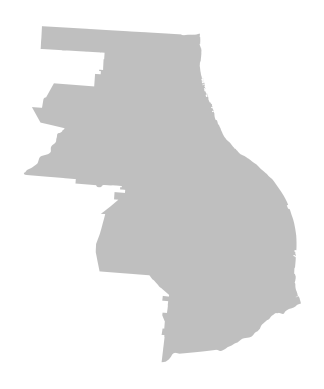

In [3]:
fig, ax = plt.subplots(1,1)
rosario_poly = ox.geocode_to_gdf("Rosario, Argentina")
rosario_poly = rosario_poly.to_crs(proj_crs)
rosario_poly.plot(ax=ax, color = "grey", alpha = 0.5)
ax.set_axis_off()


**Save as study area polygon**

In [4]:
rosario_poly.to_file("../data/study_area_polygon/study_area_polygon.gpkg", index = False)

**Get reference data**

In [5]:
gdf = gpd.read_file("ciclovias_y_bicisendas.gml")

In [6]:
# convert to projected CRS
assert gdf.crs is not None
gdf = gdf.to_crs(proj_crs)

In [7]:
gdf.head(3)

,gml_id,SE_ROW_ID,GML_ID,MSLINK,NOMBRE,CODCALLE,BIS,NUMERACION,CATEGORIA,N_PAVI,CLASE,ANIO_CONST,USO,ESTADO_SH,ESTADO_INF,RAMPAS,USABILIDAD,LONGITUD,geometry
0,ciclovias_y_bicisendas.2,2,ciclovias_y_bicisendas.4 ...,19099,PTE. PERON,53950,0,4100,Avenida,ASFALTO S/GRANITO,BICISENDA ...,999,ALTO,MALO,REGULAR,NO,BUENA,45,"LINESTRING (2560751.665 6296463.182, 2560713.0..."
1,ciclovias_y_bicisendas.3,3,ciclovias_y_bicisendas.5 ...,19100,PTE. PERON,53950,0,3900,Avenida,ASFALTO S/GRANITO,BICISENDA ...,999,ALTO,MALO,REGULAR,NO,BUENA,38,"LINESTRING (2561136.418 6296486.665, 2561104.2..."
2,ciclovias_y_bicisendas.4,4,ciclovias_y_bicisendas.6 ...,19101,PTE. PERON,53950,0,3900,Avenida,ASFALTO S/GRANITO,BICISENDA ...,999,ALTO,MALO,REGULAR,NO,BUENA,8,"LINESTRING (2561139.250 6296474.140, 2561132.1..."


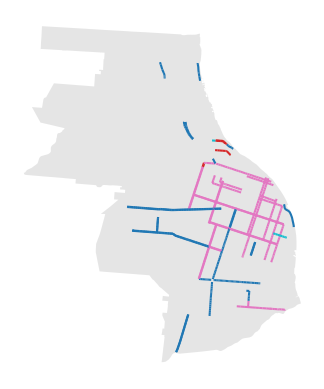

In [8]:
# visualize what we have imported
fig, ax = plt.subplots(1,1)
rosario_poly.plot(ax=ax, color = "grey", alpha = 0.2)
gdf.plot(ax=ax, column = "CLASE")
ax.set_axis_off()

**Delete not needed columns**

In [9]:
gdf.drop(columns = ['gml_id', 'SE_ROW_ID', 'GML_ID', 'MSLINK'], inplace = True)

**Make sure that all geometries are LineStrings**

In [10]:
gdf = gdf.explode(index_parts = False).reset_index(drop=True)

In [11]:
assert all(gdf.geometry.geom_type == "LineString")

**Format "CLASE" column**
(remove white spaces)

In [12]:
gdf.CLASE = gdf.apply(lambda x: x.CLASE.replace(" ", ""), axis = 1) 

In [13]:
Counter(gdf.CLASE)

Counter({'BICISENDA': 407,
         'CICLOVIA': 608,
         'CICLOVIADOBLEMANO': 8,
         'CALLECOMPARTIDA': 23})

**Add column describing geometry type**

Centerline or true geometry? Since *all* the features are true geometries, we don't need a separate column - we just add `reference_geometries: true_geometries` in the config.yml file

**Add column describing type of bicycle infrastructure (protected/unprotected)**

* Bicisendas, calle compartida: unprotected
* Ciclovias, ciclovias doble mano: protected

In [14]:
# initiate column
gdf["protection"] = "unknown"
# classify
gdf.loc[gdf["CLASE"]=="CICLOVIA", "protection"] = "protected"
gdf.loc[gdf["CLASE"]=="CICLOVIADOBLEMANO", "protection"] = "protected"
gdf.loc[gdf["CLASE"]=="BICISENDA", "protection"] = "unprotected"
gdf.loc[gdf["CLASE"]=="CALLECOMPARTIDA", "protection"] = "unprotected"


In [15]:
Counter(gdf.protection)

Counter({'unprotected': 430, 'protected': 616})

**Add column describing whether features are bidirectional**

In [16]:
# the only bidirectional one is "cicloviadoblemano"
gdf["is_bidirectional"] = False
gdf.loc[gdf["CLASE"]=="CICLOVIADOBLEMANO", "is_bidirectional"] = True

In [17]:
Counter(gdf.is_bidirectional)

Counter({False: 1038, True: 8})

### NOTE: THIS IS LIKELY FALSE >> BUT THERE IS NOT ENOUGH INFO ABOUT DOBLE SENTIDO IN THE DATA
might need to fill this out manually for a more correct analysis (as of now, the length of cycling infrastructure is underestimated!)

**Save file for qgis input**

In [18]:
gdf.to_file("refprep_qgis_input.gpkg", index = False)
del(gdf)

**Make sure LineStrings end at intersections**
(with PyQGIS)

In [19]:
myprefix = '/Applications/QGIS-LTR.app/Contents/MacOS' # location of QGIS on your PC
myinput =  "refprep_qgis_input.gpkg" # input file
myoutput = "refprep_qgis_output.gpkg" # output file

In [20]:
# Supply path to qgis install location
QgsApplication.setPrefixPath(
    myprefix, 
    False # use default paths
    )

# Create a reference to the QgsApplication. 
qgs = QgsApplication(
    [], 
    False # do *not* use GUI
    )

# Load providers
qgs.initQgis()

qt.qpa.fonts: Populating font family aliases took 136 ms. Replace uses of missing font family "Open Sans" with one that exists to avoid this cost. 


In [21]:
# initialize Processing
import processing 
from processing.core.Processing import Processing
Processing.initialize()

In [22]:
# Run processing algorithm "split with lines"
temp_out_split = processing.run(
"native:splitwithlines",
    {
        'INPUT':myinput,
        'LINES':myinput,
        'OUTPUT':'TEMPORARY_OUTPUT'
    }
)

In [23]:
# delete "FID" column
mylayer = temp_out_split["OUTPUT"]
mylayer.dataProvider().deleteAttributes([0])
mylayer.updateFields()

In [24]:
# Check validity and only keep valid layer
temp_out_valid = processing.run(
    "qgis:checkvalidity",
        {
            'INPUT_LAYER': mylayer,
            'METHOD': 2,
            'IGNORE_RING_SELF_INTERSECTION': False,
            'VALID_OUTPUT': myoutput,
            'INVALID_OUTPUT':None,
            'ERROR_OUTPUT':None
        }
    )

Read back in the qgis-processed file

In [25]:
final_gdf = gpd.read_file(myoutput)

In [26]:
final_gdf = final_gdf.explode(index_parts = False)
assert (all(final_gdf.geometry.geom_type == "LineString"))

**Make sure that every feature has a unique ID**

In [27]:
final_gdf["unique_id"] = final_gdf.index

In [28]:
final_gdf.head()

,NOMBRE,CODCALLE,BIS,NUMERACION,CATEGORIA,N_PAVI,CLASE,ANIO_CONST,USO,ESTADO_SH,ESTADO_INF,RAMPAS,USABILIDAD,LONGITUD,protection,is_bidirectional,geometry,unique_id
0,PTE. PERON,53950,0,4100,Avenida,ASFALTO S/GRANITO,BICISENDA,999,ALTO,MALO,REGULAR,NO,BUENA,45,unprotected,False,"LINESTRING (2560751.665 6296463.182, 2560713.0...",0
1,PTE. PERON,53950,0,3900,Avenida,ASFALTO S/GRANITO,BICISENDA,999,ALTO,MALO,REGULAR,NO,BUENA,38,unprotected,False,"LINESTRING (2561136.418 6296486.665, 2561104.2...",1
2,PTE. PERON,53950,0,3900,Avenida,ASFALTO S/GRANITO,BICISENDA,999,ALTO,MALO,REGULAR,NO,BUENA,8,unprotected,False,"LINESTRING (2561139.250 6296474.140, 2561132.1...",2
3,PTE. PERON,53950,0,3900,Avenida,ASFALTO S/GRANITO,BICISENDA,999,ALTO,MALO,REGULAR,NO,BUENA,31,unprotected,False,"LINESTRING (2561553.349 6296485.928, 2561527.0...",3
4,PTE. PERON,53950,0,3900,Avenida,ASFALTO S/GRANITO,BICISENDA,999,ALTO,MALO,REGULAR,NO,BUENA,93,unprotected,False,"LINESTRING (2561913.308 6296496.135, 2561833.6...",4


In [29]:
Counter(final_gdf.protection)

Counter({'unprotected': 432, 'protected': 644})

In [30]:
Counter(final_gdf.is_bidirectional)

Counter({False: 1067, True: 9})

In [31]:
# reformat string to bool
final_gdf.is_bidirectional = final_gdf.apply(
    lambda x:
    bool(x.is_bidirectional),
    axis = 1
)

In [32]:
final_gdf.head(3)

,NOMBRE,CODCALLE,BIS,NUMERACION,CATEGORIA,N_PAVI,CLASE,ANIO_CONST,USO,ESTADO_SH,ESTADO_INF,RAMPAS,USABILIDAD,LONGITUD,protection,is_bidirectional,geometry,unique_id
0,PTE. PERON,53950,0,4100,Avenida,ASFALTO S/GRANITO,BICISENDA,999,ALTO,MALO,REGULAR,NO,BUENA,45,unprotected,False,"LINESTRING (2560751.665 6296463.182, 2560713.0...",0
1,PTE. PERON,53950,0,3900,Avenida,ASFALTO S/GRANITO,BICISENDA,999,ALTO,MALO,REGULAR,NO,BUENA,38,unprotected,False,"LINESTRING (2561136.418 6296486.665, 2561104.2...",1
2,PTE. PERON,53950,0,3900,Avenida,ASFALTO S/GRANITO,BICISENDA,999,ALTO,MALO,REGULAR,NO,BUENA,8,unprotected,False,"LINESTRING (2561139.250 6296474.140, 2561132.1...",2


**Save to file/folder as required by BikeDNA**

In [33]:
final_gdf.to_file(
    "../data/REFERENCE/rosario/raw/reference_data.gpkg", 
    index = False
    )